In [ ]:
# First install dependencies (run this in terminal or Colab cell)
!pip install yfinance statsmodels

In [ ]:
!pip install requests pandas


For the purpose of example, inputs are not from a real company and are randomized.

**Volatility**

In [3]:
import numpy as np

#projected undiscounted terminal value in 2021 dollars starting 2011
cash_flows = [4000,	6000,	10000,	10000,	1000000]

#log returns
log_returns = np.diff(np.log(cash_flows))

#standard deviation
volatility_annualized = np.std(log_returns, ddof=1)

#annualized Vol
print(f"Estimated Annual Volatility: {volatility_annualized:.4f} or {volatility_annualized * 100:.2f}%")


Estimated Annual Volatility: 2.1611 or 216.11%


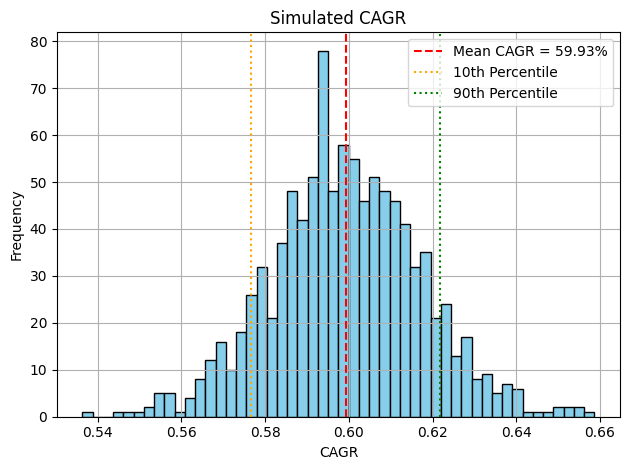

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# === INPUTS ===
start_revenue = 50000         #most recent year on the books
base_growth_rate = .6    # current cagr
volatility = 2.16 # Growth volatility (annualized) (may be proxied or taken from footnotes. Above you will find code taking the log returns of cash flows to find annualized volatility)
years = 6                      # Forecast horizon
simulations = 1000             # Number of Monte Carlo paths

# === STORAGE ===
cagr_results = []

# === SIMULATION LOOP ===
np.random.seed(42)  # Reproducible results

for _ in range(simulations):
    revenue = start_revenue

    for year in range(years):
        # Generate random economic shock
        shock = np.random.normal(loc=0, scale=volatility)

        # Real options logic
        if shock > 0.10:
            growth = base_growth_rate + shock + 0.05   # Expansion scenario
        elif shock < -0.10:
            growth = base_growth_rate + shock - 0.05   # Contraction scenario
        else:
            growth = base_growth_rate + shock          # Neutral

        # Update revenue with growth
        revenue *= (1 + growth)

    # === Calculate CAGR for this simulation ===
    cagr = (revenue / start_revenue) ** (1 / years) - 1
    cagr_results.append(cagr)

# === ANALYSIS ===
avg_cagr = np.mean(cagr_results)
p10 = np.percentile(cagr_results, 10)
p90 = np.percentile(cagr_results, 90)

# === PLOT RESULTS ===
plt.hist(cagr_results, bins=50, color='skyblue', edgecolor='black')
plt.axvline(avg_cagr, color='red', linestyle='--', label=f'Mean CAGR = {avg_cagr:.2%}')
plt.axvline(p10, color='orange', linestyle=':', label='10th Percentile')
plt.axvline(p90, color='green', linestyle=':', label='90th Percentile')
plt.title('Simulated CAGR')
plt.xlabel('CAGR')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

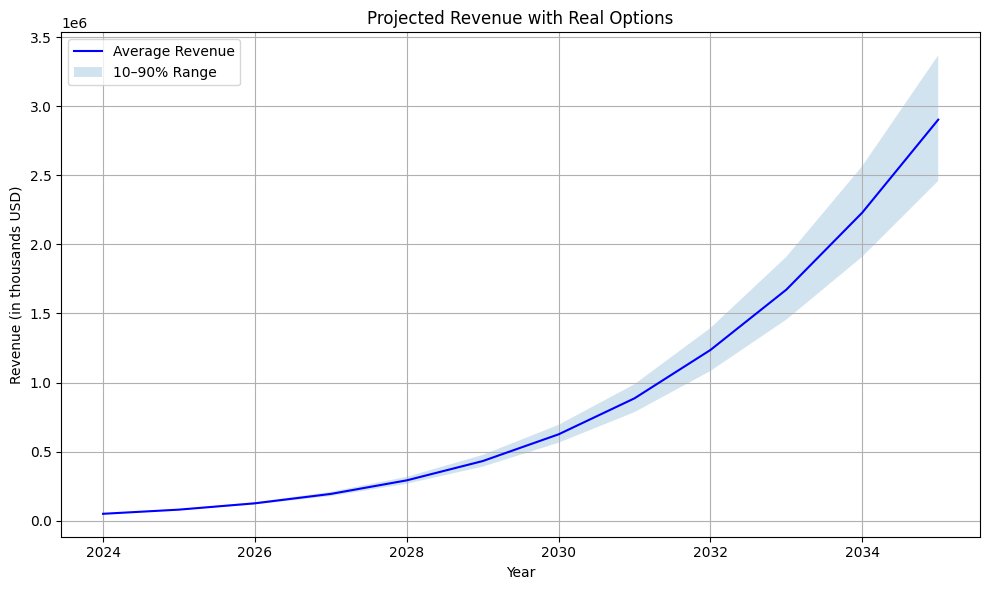

    Year  Avg Growth Rate (%)
0   2025                60.20
1   2026                57.13
2   2027                54.03
3   2028                50.68
4   2029                47.76
5   2030                44.91
6   2031                41.69
7   2032                39.49
8   2033                35.32
9   2034                33.33
10  2035                30.15


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === PARAMETERS ===
start_revenue = 50000           # 2024 revenue
base_growth_rate = .6        #
avg_growth = 0.5993            #from above (mean)
volatility = 2.16      # annualized volatility
start_year = 2024
end_year = 2035
years = end_year - start_year
simulations = 500

# === STORAGE ===
all_growth_paths = []
all_revenue_paths = []

np.random.seed(42)  # For reproducibility

# === SIMULATION LOOP ===
for _ in range(simulations):
    revenue_path = [start_revenue]
    growth_path = []

    for year in range(years):
        # Random growth shock
        shock = np.random.normal(0, volatility)

        # Dynamic base growth (taper Skype growth each year)
        decline = base_growth_rate * (1 - year * 0.1)

        # Microsoft stabilizing influence
        adjusted_growth = decline + (avg_growth - decline) * 0.5

        # Add shock
        growth = adjusted_growth + shock

        # Real options reaction
        if shock > 0.05:
            growth += 0.03  # expand
        elif shock < -0.05:
            growth -= 0.03  # contract

        growth_path.append(growth)

        # Apply growth
        new_revenue = revenue_path[-1] * (1 + growth)
        revenue_path.append(new_revenue)

    all_growth_paths.append(growth_path)
    all_revenue_paths.append(revenue_path)

# === BUILD RESULTS ===
revenue_df = pd.DataFrame(all_revenue_paths).T
growth_df = pd.DataFrame(all_growth_paths).T

years_range = np.arange(start_year, end_year + 1)
avg_revenue = revenue_df.mean(axis=1)
avg_growth = growth_df.mean(axis=1)

# === PLOT ===
q10 = revenue_df.quantile(0.1, axis=1).astype(float).values
q90 = revenue_df.quantile(0.9, axis=1).astype(float).values

plt.figure(figsize=(10, 6))
plt.plot(years_range, avg_revenue, label='Average Revenue', color='blue')
plt.fill_between(years_range, q10, q90, alpha=0.2, label='10–90% Range')
plt.title('Projected Revenue with Real Options')
plt.xlabel('Year')
plt.ylabel('Revenue (in thousands USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === EXPORTABLE GROWTH SUMMARY ===
growth_summary = pd.DataFrame({
    'Year': years_range[1:],
    'Avg Growth Rate (%)': (avg_growth * 100).round(2)
})

print(growth_summary)